In [62]:
import cv2 as cv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

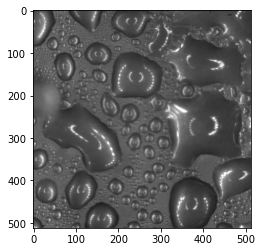

In [63]:
im_in_actual = cv.imread("C:\\Users\\grdmg\\Desktop\\image_0.tif")
plt.imshow(im_in_actual)
plt.show()

In [64]:
def unsharp_mask(image, kernel_size=(9, 9), sigma=2.0, amount=2.0, threshold=0):
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [65]:
def CC(img):
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(img)
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    return labeled_img, nlabels, labels, stats, centroids

In [66]:
def MakeWhite(image, alpha, beta): #alpha:1-3, beta:0 -100
    new_image = np.zeros(image.shape, im_in_actual.dtype)
    #alpha = 2.5  # Simple contrast control
    #beta = 10  # Simple brightness control
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y, x, c] = np.clip(alpha * image[y, x, c] + beta, 0, 255)
    new_image = cv.medianBlur(new_image, 3)
    new_image = cv.medianBlur(new_image, 5)
    new_image = cv.medianBlur(new_image, 3)
    return new_image

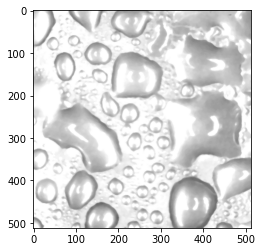

In [67]:
im_light = MakeWhite(im_in_actual, 2.5, 20) #alpha:1-3, beta:0 -100
plt.imshow(im_light)
plt.show()

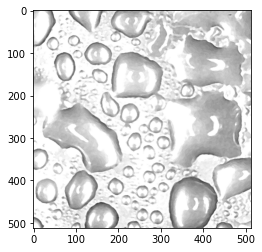

In [68]:
crop_sharp = unsharp_mask(im_light, kernel_size=(9, 9), sigma=2.0, amount=2.0, threshold=0)
crop_sharp_copy = crop_sharp
plt.imshow(crop_sharp)
plt.show()

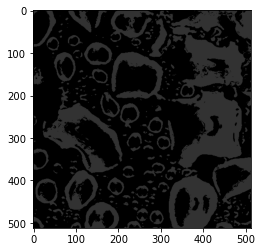

In [69]:
th, crop_sharp_th = cv.threshold(crop_sharp, 200, 50, cv.THRESH_BINARY_INV);
plt.imshow(crop_sharp_th)
plt.show()

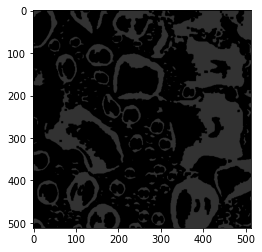

In [70]:
kernel = np.ones((2, 2), np.uint8)
dilation = cv.dilate(crop_sharp_th, kernel, iterations=3)
erosion = cv.erode(dilation , kernel, iterations=4)
plt.imshow(erosion )
plt.show()

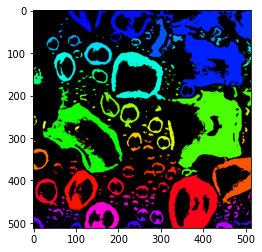

[[     0      0    512    512 168855]
 [     0      0     16     13     85]
 [     0      0     54     87    989]
 ...
 [   281    510     12      2     21]
 [   297    510      4      2      6]
 [   321    511      2      1      2]]


In [71]:
erosion = cv.cvtColor(crop_sharp_th, cv.COLOR_BGR2GRAY)
components, nlabels, labels, stats, centroids = CC(erosion)
plt.imshow(components)
plt.show()
print(stats)

In [72]:
final_stats = []
final_centroids = []
f_stat_counter = 0
for i in range(stats.shape[0]):
    if (stats[i][4] > 1000) or (stats[i][2] < 10) or (stats[i][3] < 10):
        pass
    else:
        final_stats.append(stats[i])
        final_centroids.append(centroids[i])
FStats = np.array(final_stats, dtype=object)
FCentr = np.array(final_centroids, dtype= int)
#print(FStats)
#print(FCentr)

#print(FCentr[0])

First do it for the small droplets

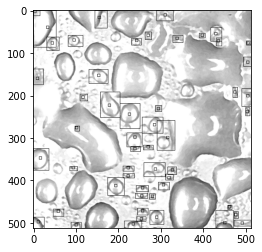

True

In [73]:
out = crop_sharp
for row in range(FCentr.shape[0]):
    X = FCentr[row][0]
    Y = FCentr[row][1]
    cv.rectangle(out, (X - 3, Y - 3), (X + 3, Y + 3), (0, 0, 0))
    cv.rectangle(out, (FStats[row][0], FStats[row][1]), (FStats[row][0] + FStats[row][2], FStats[row][1] + FStats[row][3]), (0, 0, 0))
plt.imshow(out)
plt.show()

cv.imwrite("BOXES for image_0.tif", out)

after that do it for the large droplets

In [74]:
final_stats_large = []
final_centroids_large = []
f_stat_counter_large = 0
for i in range(stats.shape[0]):
    if (stats[i][4] < 1000) or (stats[i][4] > 20000) or (stats[i][3] < 10):
        pass
    else:
        final_stats_large.append(stats[i])
        final_centroids_large.append(centroids[i])
FStatsL = np.array(final_stats_large, dtype=object)
FCentrL = np.array(final_centroids_large, dtype= int)
print(FStatsL)
#print(FCentr)

#print(FCentr[0])

[[83 0 54 53 1188]
 [182 0 102 75 3056]
 [321 0 178 204 14713]
 [438 0 74 70 2295]
 [273 20 51 91 1718]
 [120 75 66 55 1393]
 [49 99 51 73 1343]
 [184 98 128 114 5113]
 [23 180 187 203 9646]
 [325 187 166 204 15698]
 [421 346 91 110 3539]
 [74 376 79 95 3202]
 [319 386 115 126 8326]
 [6 396 52 65 1117]
 [121 451 81 61 2531]]


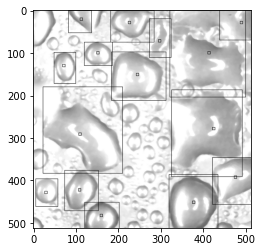

True

In [75]:
outLARGE = im_light
for row in range(FCentrL.shape[0]):
    XL = FCentrL[row][0]
    YL = FCentrL[row][1]
    cv.rectangle(outLARGE, (XL - 3, YL - 3), (XL + 3, YL + 3), (0, 0, 0))
    cv.rectangle(outLARGE, (FStatsL[row][0], FStatsL[row][1]), (FStatsL[row][0] + FStatsL[row][2], FStatsL[row][1] + FStatsL[row][3]), (0, 0, 0))
plt.imshow(outLARGE)
plt.show()

cv.imwrite("BOXES LLL for image_0.tif", outLARGE)

In [79]:
MatrixS = np.zeros((FStats.shape[0], 6), dtype=int)
for row in range(FStats.shape[0]):
    MatrixS[row][0] = FCentr[row][0]  # X centroid
    MatrixS[row][1] = FCentr[row][1]  # Y centroid
    MatrixS[row][2] = FStats[row][2]  # H size
    MatrixS[row][3] = FStats[row][3]  # V size 
    MatrixS[row][4] = FStats.shape[0]  # Total number of small droplets 
    MatrixS[row][5] = FStats[row][4]    # Area in pixels 

my_df_S = pd.DataFrame(MatrixS)
my_df_S.columns = ['X centroid', 'Y centroid', 'Horizontal Size', 'Vertical Size', 'Total number of droplets',
                       'Single Droplet Area']
my_df_S.to_csv(f'matrix SMALL from frame.csv', index=False)  # save as csv

MatrixL = np.zeros((FStatsL.shape[0], 6), dtype=int)
for row in range(FStatsL.shape[0]):
    MatrixL[row][0] = FCentrL[row][0]  # X centroid
    MatrixL[row][1] = FCentrL[row][1]  # Y centroid
    MatrixL[row][2] = FStatsL[row][2]  # H size
    MatrixL[row][3] = FStatsL[row][3]  # V size 
    MatrixL[row][4] = FStatsL.shape[0]  # Total number of small droplets 
    MatrixL[row][5] = FStatsL[row][4]    # Area in pixels 

my_df_L = pd.DataFrame(MatrixL)
my_df_L.columns = ['X centroid', 'Y centroid', 'Horizontal Size', 'Vertical Size', 'Total number of droplets',
                       'Single Droplet Area']
my_df_L.to_csv(f'matrix LARGE from frame.csv', index=False)  # save as csv